In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import json
from pathlib import Path

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
path = '/Users/haohe/Documents/HKUST/research_related/crowd_counting/benchmark'
images = path + '/data/images'
anno = path + '/data/annotations'

In [62]:
with open(anno+'/s4.json','r') as f:
    data = json.load(f)

In [19]:
data['shapes']

[{'line_color': None,
  'shape_type': 'point',
  'points': [555.4731335984076, 1343.4311146757393],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [573.9244377940078, 1365.1560373576558],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [626.8975369362147, 1346.7047331620556],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [556.7466518160867, 1217.7018347135481],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [918.708765383124, 1060.321760187672],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [970.9727767266345, 1261.2452922978744],
  'flags': {},
  'fill_color': None,
  'label': '人'},
 {'line_color': None,
  'shape_type': 'point',
  'points': [1080.6609401312758

In [63]:
image = cv2.imread(images+'/s4.jpg',cv2.IMREAD_COLOR)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.

In [21]:
image.shape

(1530, 2720, 3)

In [38]:
x, y = data['shapes'][0]['points']
int(x)

555

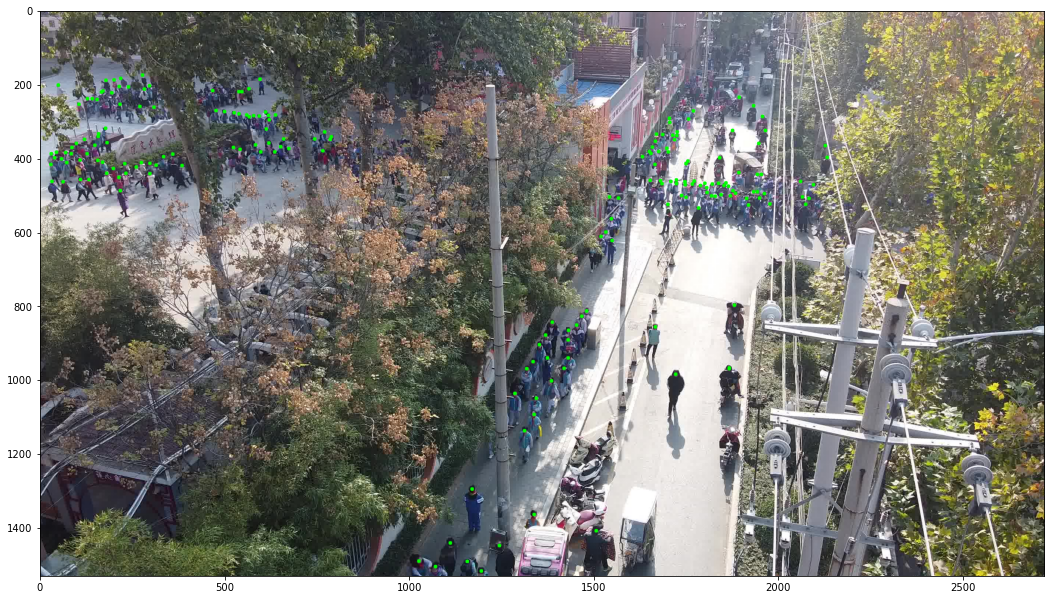

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for datas in data['shapes']:
    x,y = datas['points']
    point =(int(x),int(y))
    cv2.circle(image, point, radius=0,color=(0, 1, 0), thickness=10)
    
#ax.set_axis_off()
ax.imshow(image);

In [75]:
def generate_density_map_with_fixed_kernel(img,points,kernel_size=15,sigma=2.0):
    '''
    img: input image.
    points: annotated pedestrian's position like [row,col]
    kernel_size: the fixed size of gaussian kernel, must be odd number.
    sigma: the sigma of gaussian kernel.
    return:
    d_map: density-map we want
    '''
    def guassian_kernel(size,sigma):
        rows=size[0] # mind that size must be odd number.
        cols=size[1]
        mean_x=int((rows-1)/2)
        mean_y=int((cols-1)/2)

        f=np.zeros(size)
        for x in range(0,rows):
            for y in range(0,cols):
                mean_x2=(x-mean_x)*(x-mean_x)
                mean_y2=(y-mean_y)*(y-mean_y)
                f[x,y]=(1.0/(2.0*np.pi*sigma*sigma))*np.exp((mean_x2+mean_y2)/(-2.0*sigma*sigma))
        return f

    [rows,cols]=[img.shape[0],img.shape[1]]
    d_map=np.zeros([rows,cols])
    f=guassian_kernel([kernel_size,kernel_size],sigma) # generate gaussian kernel with fixed size.
    normed_f=(1.0/f.sum())*f # normalization for each head.

    if len(points)==0:
        return d_map
    else:
        for p in points:
            r,c=int(p[0]),int(p[1])
            if r>=rows or c>=cols:
                continue
            for x in range(0,f.shape[0]):
                for y in range(0,f.shape[1]):
                    if x+((r+1)-int((f.shape[0]-1)/2))<0 or x+((r+1)-int((f.shape[0]-1)/2))>rows-1 \
                    or y+((c+1)-int((f.shape[1]-1)/2))<0 or y+((c+1)-int((f.shape[1]-1)/2))>cols-1:
                        continue
                    else:
                        d_map[x+((r+1)-int((f.shape[0]-1)/2)),y+((c+1)-int((f.shape[1]-1)/2))]+=normed_f[x,y]
    return d_map

In [67]:
points = []
for datas in data['shapes']:
    x,y = datas['points']
    points.append((x,y))

In [76]:
d_map = generate_density_map_with_fixed_kernel(image,points)

In [70]:
d_map.shape

(1530, 2720)

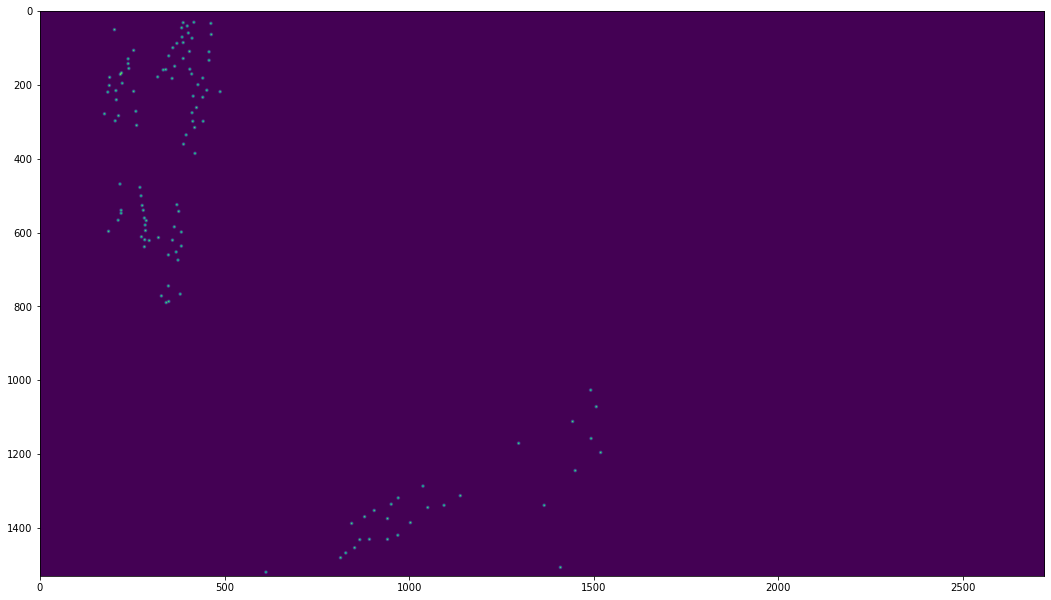

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.imshow(d_map)

In [78]:
d_map.sum()

116.99999999999991

In [79]:
len(points)

201

In [82]:
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
def gaussian_filter_density(img,points):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.
    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.
    return:
    density: the density-map we want. Same shape as input image but only has one channel.
    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    img_shape=[img.shape[0],img.shape[1]]
    print("Shape of current image: ",img_shape,". Totally need generate ",len(points),"gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=4)

    print ('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1])<img_shape[0] and int(pt[0])<img_shape[1]:
            pt2d[int(pt[1]),int(pt[0])] = 1.
        else:
            continue
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [88]:
%%time
d_map_1 = gaussian_filter_density(image,points)

Shape of current image:  [1530, 2720] . Totally need generate  201 gaussian kernels.
generate density...
done.
CPU times: user 1min 18s, sys: 831 ms, total: 1min 19s
Wall time: 1min 19s


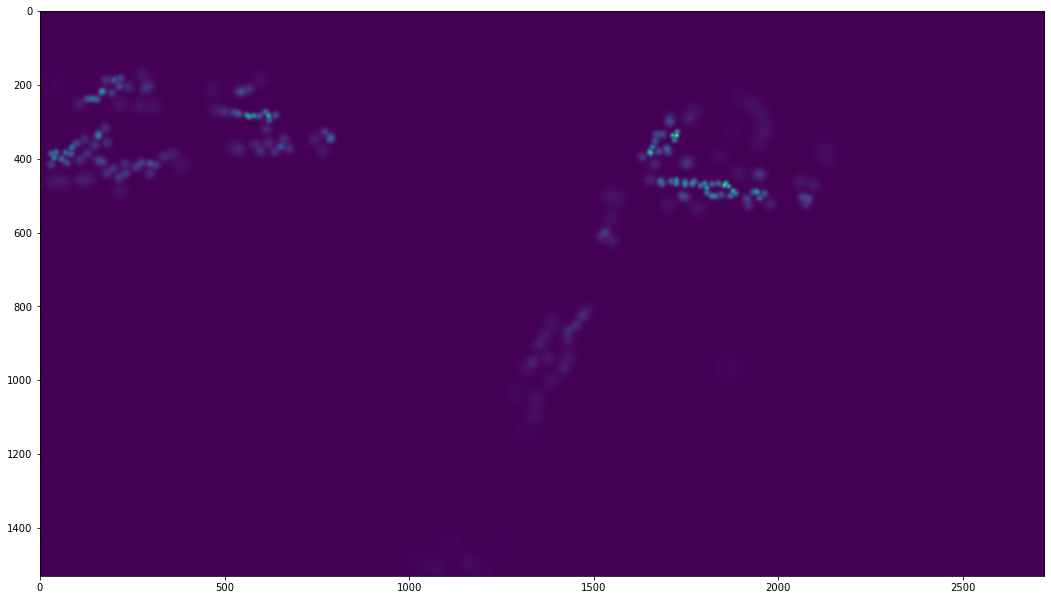

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.imshow(d_map_1)

In [85]:
d_map_1.sum()

200.40137